# SETUP

In [63]:
import pandas as pd

import numpy as np

import pydicom as dicom

import matplotlib.pyplot as plt

from glob import glob

import seaborn as sns

import cv2

import torch
import torchvision

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, Subset
from torch.utils.data import ConcatDataset
import torchvision.models as models
import torch.optim as optim
from torchvision import models

from transformers import ViTForImageClassification, ViTFeatureExtractor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from PIL import Image

import timm

import os

from tqdm import tqdm

import random

import gc

import warnings

import time

warnings.filterwarnings("ignore")
%matplotlib inline

In [64]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print('seeding done!!!')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    print('Memory Flushed')

In [65]:
seeding(2024)
flush()

seeding done!!!
Memory Flushed


# BUILDING DATASET

## Create file paths

In [66]:
# Function to create a list of image file paths
def make_datapath_list(root_dir):
    data_paths = []
    class_names = os.listdir(root_dir)
    
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data_paths.append((image_path, class_name))
    
    return data_paths

# Function to create a list of 'Healthy' image file paths
def make_healthy_datapath_list(root_dir):
    data_paths = []
    target_path = os.path.join(root_dir, 'Healthy', '*.jpg')
    
    for path in glob(target_path):
        data_paths.append((path, 'Healthy'))
    
    return data_paths

## Create Dataset Class

In [67]:
# Dataset class for Spine images
class SpineDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.class_to_index = {'Healthy': 0, 'Patient': 1}

    def __len__(self):
        return len(self.data_paths)
    
    def get_labels(self):
        labels = [label for _, label in self.data_paths]
        label_indices = [self.class_to_index[label] for label in labels]
        return label_indices

    def __getitem__(self, idx):
        image_path, label = self.data_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label_idx = self.class_to_index[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return {'image': image, 'label': label_tensor}

# Dataset class for Healthy Spine images with augmented transforms
class HealthySpineDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.class_to_index = {'Healthy': 0, 'Patient': 1}

    def __len__(self):
        return len(self.data_paths)
    
    def get_labels(self):
        labels = [label for _, label in self.data_paths]
        label_indices = [self.class_to_index[label] for label in labels]
        return label_indices

    def __getitem__(self, idx):
        image_path, label = self.data_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label_idx = self.class_to_index[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return {'image': image, 'label': label_tensor}

# Custom ConcatDataset to get labels
class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super(CustomConcatDataset, self).__init__(datasets)
    
    def get_labels(self):
        results = []
        for dataset in self.datasets:
            if hasattr(dataset, 'get_labels'):
                results.extend(dataset.get_labels())
        return results

In [68]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmented_train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmented_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [69]:
# Create datapath lists
root_dir = "/kaggle/input/spine-mri-nchu/Original"

spine_datapath = make_datapath_list(root_dir)

spine_train_datapath, spine_val_datapath = train_test_split(spine_datapath, test_size=0.2, random_state=42)

# # First split: 80% train, 20% temp (validation + test)
# spine_train_datapath, temp_datapath = train_test_split(spine_datapath, test_size=0.2, random_state=42)
# # Second split: 50% of temp for validation and 50% for test
# spine_val_datapath, spine_test_datapath = train_test_split(temp_datapath, test_size=0.5, random_state=42)



spine_train_dataset = SpineDataset(spine_train_datapath, transform=train_transform)
spine_val_dataset = SpineDataset(spine_val_datapath, transform=val_transform)

healthy_spine_datapath = make_healthy_datapath_list(root_dir)
healthy_spine_train_datapath, healthy_spine_val_datapath = train_test_split(healthy_spine_datapath, test_size=0.2, random_state=42)

augmented_healthy_spine_train_dataset = HealthySpineDataset(healthy_spine_train_datapath, transform=augmented_train_transform)
augmented_healthy_spine_val_dataset = HealthySpineDataset(healthy_spine_val_datapath, transform=val_transform)

combined_spine_train_dataset = CustomConcatDataset([spine_train_dataset, augmented_healthy_spine_train_dataset])
combined_spine_val_dataset = CustomConcatDataset([spine_val_dataset, augmented_healthy_spine_val_dataset])

In [70]:
# Get the sizes of the datasets
spine_train_size = len(spine_train_dataset)
spine_val_size = len(spine_val_dataset)
healthy_train_size = len(augmented_healthy_spine_train_dataset)
healthy_val_size = len(augmented_healthy_spine_val_dataset)
combined_train_size = len(combined_spine_train_dataset)
combined_val_size = len(combined_spine_val_dataset)

# Print the sizes
print(f"Size of spine_train_dataset: {spine_train_size}")
print(f"Size of spine_val_dataset: {spine_val_size}")
print(f"Size of augmented_healthy_spine_train_dataset: {healthy_train_size}")
print(f"Size of augmented_healthy_spine_val_dataset: {healthy_val_size}")
print(f"Size of combined_spine_train_dataset: {combined_train_size}")
print(f"Size of combined_spine_val_dataset: {combined_val_size}")

Size of spine_train_dataset: 153
Size of spine_val_dataset: 39
Size of augmented_healthy_spine_train_dataset: 50
Size of augmented_healthy_spine_val_dataset: 13
Size of combined_spine_train_dataset: 203
Size of combined_spine_val_dataset: 52


## Create DataLoader Class with WeightedRandomSampler

In [71]:
# DataLoader with WeightedRandomSampler
batch_size = 16
class_weights = torch.tensor([1, 1], dtype=torch.float)

# Training DataLoader
train_labels = combined_spine_train_dataset.get_labels()
samples_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights=samples_weights, 
                                num_samples=len(samples_weights), 
                                replacement=True)

spine_train_loader = DataLoader(
    combined_spine_train_dataset,
    batch_size=batch_size,
    sampler=sampler
)

# Validation DataLoader
val_labels = combined_spine_val_dataset.get_labels()
samples_weights = class_weights[val_labels]
sampler = WeightedRandomSampler(weights=samples_weights, 
                                num_samples=len(samples_weights), 
                                replacement=True)

spine_val_loader = DataLoader(
    combined_spine_val_dataset,
    batch_size=batch_size,
    sampler=sampler
)

In [72]:
# # DataLoader with WeightedRandomSampler
# batch_size = 16
# class_weights = torch.tensor([1, 1], dtype=torch.float)

# # Training DataLoader
# train_labels = spine_train_dataset.get_labels()
# samples_weights = class_weights[train_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_train_loader = DataLoader(
#     spine_train_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

# # Validation DataLoader
# val_labels = spine_val_dataset.get_labels()
# samples_weights = class_weights[val_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_val_loader = DataLoader(
#     spine_val_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

## Show images in the dataset

In [73]:
# def imshow(img, ax):
#     """Function to show an image"""
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     ax.imshow(np.transpose(npimg, (1, 2, 0)))
#     ax.axis('off')

# def show_images_from_loader(loader, num_images_per_row=16):
#     """Function to show images from a DataLoader in a grid"""
#     for batch in loader:
#         images = batch['image']
#         labels = batch['label']
        
#         num_images = images.size(0)
#         num_rows = (num_images + num_images_per_row - 1) // num_images_per_row
        
#         fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(num_images_per_row * 2, num_rows * 2))
#         fig.suptitle('Images and Labels')
        
#         for i in range(num_images):
#             row = i // num_images_per_row
#             col = i % num_images_per_row
#             ax = axes[row, col] if num_rows > 1 else axes[col]
#             imshow(images[i], ax)
#             ax.set_title(f'Label: {labels[i].item()}')

#         # Hide any unused subplots
#         for i in range(num_images, num_rows * num_images_per_row):
#             row = i // num_images_per_row
#             col = i % num_images_per_row
#             ax = axes[row, col] if num_rows > 1 else axes[col]
#             ax.axis('off')

#         plt.show()

# # Assuming spinal_train_loader and spinal_val_loader are already defined
# # Display images from the training dataset
# print("Training Dataset Images:")
# show_images_from_loader(spine_train_loader)

# # Display images from the validation dataset
# print("Validation Dataset Images:")
# show_images_from_loader(spine_val_loader)

# BUILD MODEL

In [74]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device: ", device)
# num_classes = 1  # Binary classification (Patient, Healthy)

# # Load the EfficientNet model with pretrained weights
# spine_model = models.efficientnet_v2_s(pretrained=True)
# # spine_model = models.vgg16(pretrained=False)
# # spine_model = models.mobilenet_v2(pretrained=True)

# #print(spine_model)

Device:  cuda


In [75]:
# # Modify the classifier part
# # spine_model.classifier = nn.Sequential(
# #     nn.Linear(spine_model.classifier[-1].in_features, 512),
# #     nn.ReLU(),
# #     nn.Dropout(0.5),
# #     nn.Linear(512, num_classes),
# # )

# spine_model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=1280, out_features=num_classes, bias=True)
# )

# #print(spine_model)

In [ ]:
from transformers import ViTModel, ViTFeatureExtractor

class CombinedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CombinedModel, self).__init__()

        # Pre-trained ResNet model for feature extraction
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

        # Pre-trained Vision Transformer model for feature extraction
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Fully connected layer to combine features
        self.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features + self.vit.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features using ResNet
        resnet_features = self.resnet(x)
        
        # Extract features using ViT
        vit_features = self.vit(x)['last_hidden_state'][:, 0, :]  # Use the [CLS] token representation
        
        # Concatenate features from both models
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        
        # Pass the combined features through the fully connected layers
        output = self.fc(combined_features)
        return output

In [ ]:
# Instantiate the model
model = CombinedModel(num_classes=2)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TRAIN MODEL

In [76]:
# # Freeze all parameters in the model
# for param in spine_model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer of the feature extractor (before the classifier)
# for layer in list(spine_model.features.children())[-1:]:
#     if not isinstance(layer, nn.BatchNorm2d):
#         for param in layer.parameters():
#             param.requires_grad = True

# # Unfreeze all parameters in the classifier part
# for param in spine_model.classifier.parameters():
#     param.requires_grad = True

In [77]:
spine_model.to(device)

# Define the optimizer, scheduler, and loss function
#spinal_optimizer = optim.Adam(spinal_model.parameters(), lr=1e-4, weight_decay=1e-4)
spine_optimizer = optim.Adam(spine_model.parameters(), lr=1e-4)
#spinal_scheduler = optim.lr_scheduler.StepLR(spinal_optimizer, step_size=1, gamma=0.2)
spine_loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for stabilit

In [78]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []


val_losses = []
val_accuracies = []

num_epochs = 50

best_val_loss = float('inf')
patience, trials = 2, 0

# DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    spine_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_predictions = []

    with tqdm(total=len(spine_train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch in spine_train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)  # Ensure correct shape and type
            
            spine_optimizer.zero_grad()
            outputs = spine_model(images)  # Raw logits
            loss = spine_loss_fn(outputs, labels)  # BCEWithLogitsLoss
            loss.backward()
            spine_optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities for accuracy calculation
            predicted = (preds > 0.5).long()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.update(1)

    train_loss = running_loss / len(spine_train_loader)
    train_accuracy = correct_predictions / total_samples

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    spine_model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for batch in spine_val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            outputs = spine_model(images)
            loss = spine_loss_fn(outputs, labels)

            val_running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            predicted = (preds > 0.5).long()
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss = val_running_loss / len(spine_val_loader)
    val_accuracy = val_correct_predictions / val_total_samples
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"Duration: {epoch_duration:.2f} seconds")

    # Add metrics to DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss],
        'Train Accuracy': [train_accuracy],
        'Val Loss': [val_loss],
        'Val Accuracy': [val_accuracy],
    })], ignore_index=True)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trials = 0
        torch.save(spine_model.state_dict(), 'model_best_stage1.pth')
    else:
        trials += 1
        if trials >= patience:
            print('Early stopping')
            break

Epoch 1/50: 100%|██████████| 13/13 [00:03<00:00,  3.81batch/s]


Epoch 1/50, Train Loss: 0.6600, Train Accuracy: 0.6207, Val Loss: 0.6885, Val Accuracy: 0.5962, Duration: 3.88 seconds


Epoch 2/50: 100%|██████████| 13/13 [00:03<00:00,  3.75batch/s]


Epoch 2/50, Train Loss: 0.5400, Train Accuracy: 0.8177, Val Loss: 0.5864, Val Accuracy: 0.6923, Duration: 3.92 seconds


Epoch 3/50: 100%|██████████| 13/13 [00:03<00:00,  3.78batch/s]


Epoch 3/50, Train Loss: 0.4315, Train Accuracy: 0.8177, Val Loss: 0.3854, Val Accuracy: 0.8846, Duration: 3.93 seconds


Epoch 4/50: 100%|██████████| 13/13 [00:03<00:00,  3.86batch/s]


Epoch 4/50, Train Loss: 0.2729, Train Accuracy: 0.9113, Val Loss: 0.3781, Val Accuracy: 0.8462, Duration: 3.95 seconds


Epoch 5/50: 100%|██████████| 13/13 [00:03<00:00,  3.76batch/s]


Epoch 5/50, Train Loss: 0.1584, Train Accuracy: 0.9704, Val Loss: 0.1481, Val Accuracy: 0.9423, Duration: 3.92 seconds


Epoch 6/50: 100%|██████████| 13/13 [00:03<00:00,  3.86batch/s]


Epoch 6/50, Train Loss: 0.1307, Train Accuracy: 0.9606, Val Loss: 0.1460, Val Accuracy: 0.9231, Duration: 3.81 seconds


Epoch 7/50: 100%|██████████| 13/13 [00:03<00:00,  3.75batch/s]


Epoch 7/50, Train Loss: 0.1589, Train Accuracy: 0.9557, Val Loss: 0.1004, Val Accuracy: 0.9615, Duration: 3.97 seconds


Epoch 8/50: 100%|██████████| 13/13 [00:03<00:00,  3.88batch/s]


Epoch 8/50, Train Loss: 0.1243, Train Accuracy: 0.9655, Val Loss: 0.1455, Val Accuracy: 1.0000, Duration: 3.80 seconds


Epoch 9/50: 100%|██████████| 13/13 [00:03<00:00,  3.85batch/s]


Epoch 9/50, Train Loss: 0.0452, Train Accuracy: 0.9951, Val Loss: 0.1250, Val Accuracy: 0.9615, Duration: 3.82 seconds
Early stopping


In [79]:
# Display the metrics table
metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.660044,0.620690,0.688516,0.596154
1,2,0.539959,0.817734,0.586398,0.692308
2,3,0.431526,0.817734,0.385430,0.884615
3,4,0.272942,0.911330,0.378132,0.846154
4,5,0.158352,0.970443,0.148121,0.942308
5,6,0.130703,0.960591,0.145999,0.923077
6,7,0.158900,0.955665,0.100388,0.961538
7,8,0.124286,0.965517,0.145511,1.000000
8,9,0.045162,0.995074,0.124952,0.961538


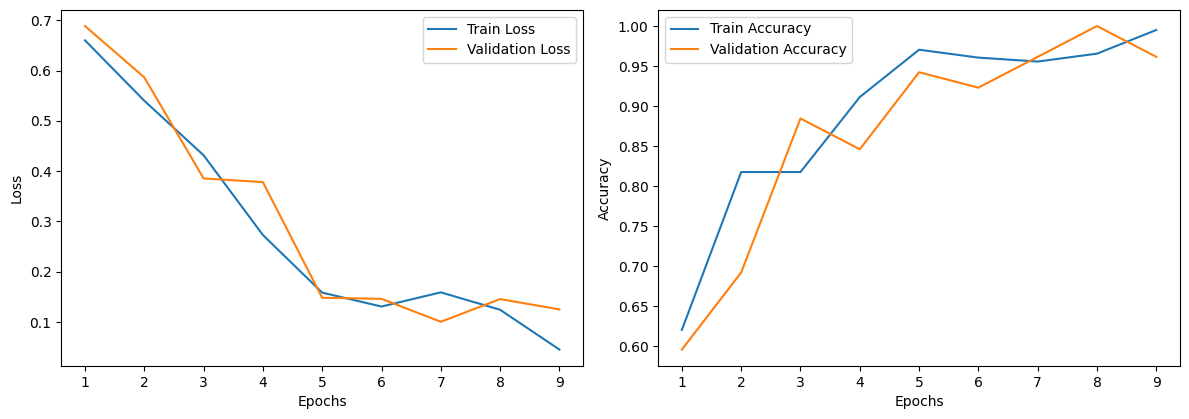

In [80]:
# Plotting training and validation metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
# Load the best model
spine_model.load_state_dict(torch.load('model_best_stage1.pth'))

<All keys matched successfully>

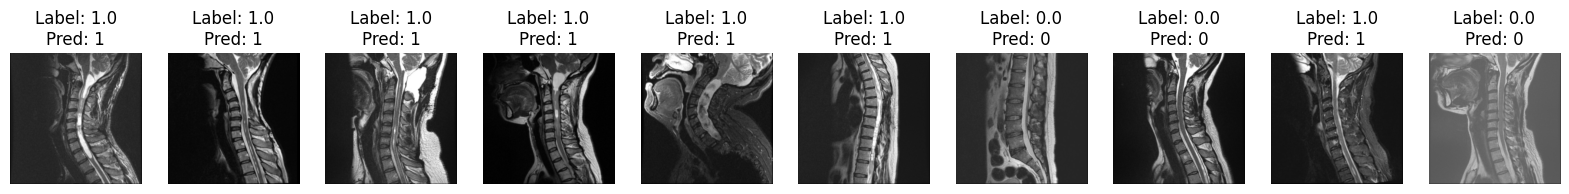

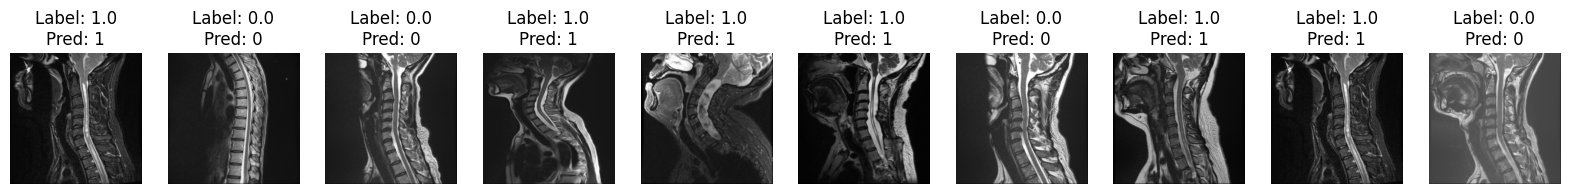

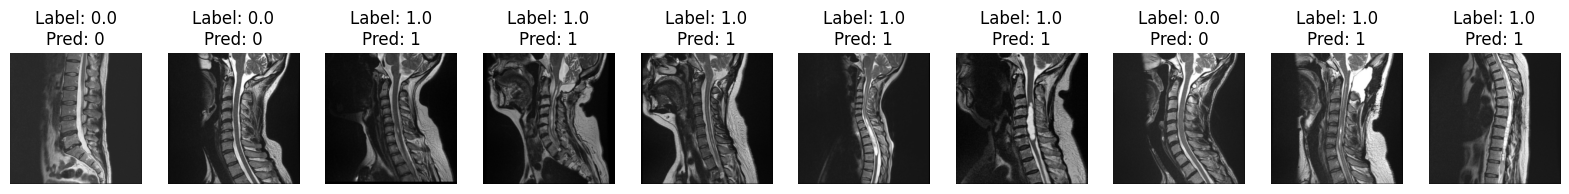

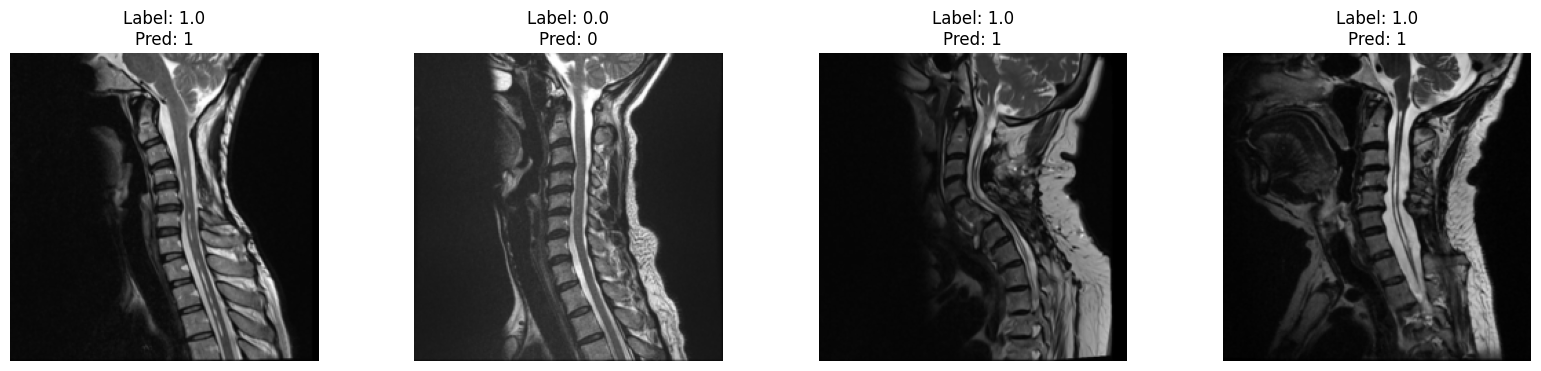

In [82]:
# Function to show an image
def imshow(img, title=None):
    """Function to show an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Function to show a grid of images with their predicted labels
def show_images_with_predictions(images, labels, preds, num_images=10):
    """Function to show images with their predicted labels"""
    num_images = min(num_images, len(images))  # Adjust num_images if fewer images are available
    images = images[:num_images]  # Get the first num_images images
    labels = labels[:num_images]
    preds = preds[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        label = labels[idx].item()
        pred = preds[idx].item()
        ax.set_title(f"Label: {label}\nPred: {pred}")
        ax.axis('off')
    plt.show()

# Use the validation dataset to predict and generate confusion matrix
spine_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in spine_val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device).float().unsqueeze(1)
        outputs = spine_model(images)
        preds = torch.sigmoid(outputs)
        predicted = (preds > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Show images with predictions
        show_images_with_predictions(images.cpu(), labels.cpu(), predicted.cpu(), num_images=10)

In [83]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(precision)
print(recall)
print(f1)

1.0
1.0
1.0


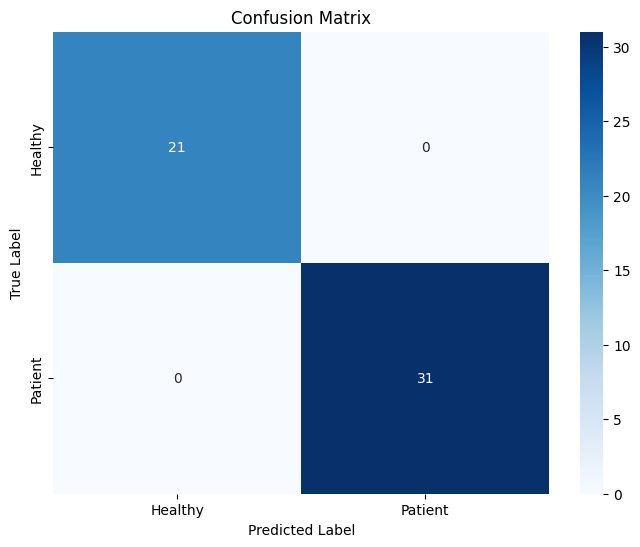

In [84]:
# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [85]:
# # # Freeze all parameters in the model
# # for param in spine_model.parameters():
# #     param.requires_grad = False

# # Unfreeze the last 2 layer of the feature extractor (before the classifier)
# for layer in list(spine_model.features.children())[-2:]:
#     if not isinstance(layer, nn.BatchNorm2d):
#         for param in layer.parameters():
#             param.requires_grad = True

# # Unfreeze all parameters in the classifier part
# for param in spine_model.classifier.parameters():
#     param.requires_grad = True

In [86]:
# spine_model.to(device)

# # Define the optimizer, scheduler, and loss function
# #spinal_optimizer = optim.Adam(spinal_model.parameters(), lr=1e-4, weight_decay=1e-4)
# spine_optimizer = optim.Adam(spine_model.parameters(), lr=1e-7)
# #spinal_scheduler = optim.lr_scheduler.StepLR(spinal_optimizer, step_size=1, gamma=0.2)
# spine_loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for stabilit

In [87]:
# # Initialize lists to store metrics
# train_losses = []
# train_accuracies = []


# val_losses = []
# val_accuracies = []

# num_epochs = 50

# best_val_loss = float('inf')
# patience, trials = 2, 0

# # DataFrame to store metrics
# metrics_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])

# for epoch in range(num_epochs):
#     epoch_start_time = time.time()
    
#     spine_model.train()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_samples = 0

#     all_labels = []
#     all_predictions = []

#     with tqdm(total=len(spine_train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
#         for batch in spine_train_loader:
#             images = batch['image'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)  # Ensure correct shape and type
            
#             spine_optimizer.zero_grad()
#             outputs = spine_model(images)  # Raw logits
#             loss = spine_loss_fn(outputs, labels)  # BCEWithLogitsLoss
#             loss.backward()
#             spine_optimizer.step()

#             running_loss += loss.item()
#             preds = torch.sigmoid(outputs)  # Convert logits to probabilities for accuracy calculation
#             predicted = (preds > 0.5).long()
#             correct_predictions += (predicted == labels).sum().item()
#             total_samples += labels.size(0)
            
#             all_labels.extend(labels.cpu().numpy())
#             all_predictions.extend(predicted.cpu().numpy())

#             pbar.update(1)

#     train_loss = running_loss / len(spine_train_loader)
#     train_accuracy = correct_predictions / total_samples

#     train_losses.append(train_loss)
#     train_accuracies.append(train_accuracy)

#     spine_model.eval()
#     val_running_loss = 0.0
#     val_correct_predictions = 0
#     val_total_samples = 0

#     all_val_labels = []
#     all_val_predictions = []

#     with torch.no_grad():
#         for batch in spine_val_loader:
#             images = batch['image'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
#             outputs = spine_model(images)
#             loss = spine_loss_fn(outputs, labels)

#             val_running_loss += loss.item()
#             preds = torch.sigmoid(outputs)
#             predicted = (preds > 0.5).long()
#             val_correct_predictions += (predicted == labels).sum().item()
#             val_total_samples += labels.size(0)
            
#             all_val_labels.extend(labels.cpu().numpy())
#             all_val_predictions.extend(predicted.cpu().numpy())

#     val_loss = val_running_loss / len(spine_val_loader)
#     val_accuracy = val_correct_predictions / val_total_samples
    
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)

#     epoch_end_time = time.time()
#     epoch_duration = epoch_end_time - epoch_start_time

#     print(f"Epoch {epoch+1}/{num_epochs}, "
#           f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
#           f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
#           f"Duration: {epoch_duration:.2f} seconds")

#     # Add metrics to DataFrame
#     metrics_df = pd.concat([metrics_df, pd.DataFrame({
#         'Epoch': [epoch + 1],
#         'Train Loss': [train_loss],
#         'Train Accuracy': [train_accuracy],
#         'Val Loss': [val_loss],
#         'Val Accuracy': [val_accuracy],
#     })], ignore_index=True)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         trials = 0
#         torch.save(spine_model.state_dict(), 'model_best_stage2.pth')
#     else:
#         trials += 1
#         if trials >= patience:
#             print('Early stopping')
#             break

In [88]:
# # Display the metrics table
# metrics_df

In [89]:
# # Plotting training and validation metrics
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
# plt.plot(epochs, train_losses, label='Train Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 2, 2)
# plt.plot(epochs, train_accuracies, label='Train Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [90]:
# # Load the best model
# spine_model.load_state_dict(torch.load('model_best_stage2.pth'))

In [91]:
# # Function to show an image
# def imshow(img, title=None):
#     """Function to show an image"""
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     if title is not None:
#         plt.title(title)
#     plt.show()

# # Function to show a grid of images with their predicted labels
# def show_images_with_predictions(images, labels, preds, num_images=10):
#     """Function to show images with their predicted labels"""
#     num_images = min(num_images, len(images))  # Adjust num_images if fewer images are available
#     images = images[:num_images]  # Get the first num_images images
#     labels = labels[:num_images]
#     preds = preds[:num_images]
    
#     fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
#     for idx in range(num_images):
#         ax = axes[idx]
#         img = images[idx] / 2 + 0.5  # unnormalize
#         npimg = img.numpy()
#         ax.imshow(np.transpose(npimg, (1, 2, 0)))
#         label = labels[idx].item()
#         pred = preds[idx].item()
#         ax.set_title(f"Label: {label}\nPred: {pred}")
#         ax.axis('off')
#     plt.show()

# # Use the validation dataset to predict and generate confusion matrix
# spine_model.eval()
# all_labels = []
# all_preds = []

# with torch.no_grad():
#     for batch in spine_val_loader:
#         images = batch['image'].to(device)
#         labels = batch['label'].to(device).float().unsqueeze(1)
#         outputs = spine_model(images)
#         preds = torch.sigmoid(outputs)
#         predicted = (preds > 0.5).long()

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())

#         # Show images with predictions
#         show_images_with_predictions(images.cpu(), labels.cpu(), predicted.cpu(), num_images=10)

In [92]:
# precision = precision_score(all_labels, all_preds)
# recall = recall_score(all_labels, all_preds)
# f1 = f1_score(all_labels, all_preds)

# print(precision)
# print(recall)
# print(f1)

In [93]:
# # Generate and print confusion matrix
# cm = confusion_matrix(all_labels, all_preds)
# print('Confusion Matrix:')
# print(cm)